### Pasar de la base de datos a diccionario

In [1]:
# Preparación de ambiente
import pandas as pd
import numpy as np

In [2]:
# Funciones útiles

def convert(ruta): 
    s = [str(i) for i in ruta] 
    ruta_c = "-".join(s)
    return(ruta_c) 

In [3]:
#Cargamos el csv con los datos
df = pd.read_csv("C:/Users/anabc/Documents/MCD/Primavera2020/MNO/Proyecto final/base.csv", sep = ',',encoding='latin-1')

In [4]:
#Creación de función que genera el diccionario necesario para ingresar al algoritmo
def diccionario_lugares(df,fv):
    """
    Función para generar un diccinario con los lugares que visita una fuerza de venta.
    Args:
        df (dataFrame): DataFrame con la base de datos
        fv (int): Fuerza de venta del que queremos generar el diccionario.
    Returns:
        lugares(diccionario): incluye los puntos que debe visitar con sus coordenas. 
    """
    df2 = df[(df.fza_ventas == fv)]
    df2['lugar'] = range(1, len(df2) + 1)
    df2 = df2.append({'lugar' : 'base' , 'lat_destino' : df2.iloc[0]['lat_origen'],'lon_destino': df2.iloc[0]['lon_origen'] } , ignore_index=True)
    df3 = df2[['lugar','lat_destino','lon_destino']].copy()
    lugares = {a:(b,c)for a, b, c in df3.values}
    return lugares

In [5]:
lugares = diccionario_lugares(df,37831)
#Podemos probar con estas fuerza de venta:
# 94459- 6 lugares, Nuevo león
# 37831- 30 lugares, Jalisco
#  14738- 58 lugares, Ciudad de México

C:\Users\anabc\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':


In [6]:
lugares

{1: (20.62551262, -103.24522409999999),
 2: (20.65018692, -103.2510411),
 3: (20.64372595, -103.2586353),
 4: (20.6418104, -103.2531518),
 5: (20.64292562, -103.2578913),
 6: (20.63051004, -103.2380119),
 7: (20.64218265, -103.25934709999999),
 8: (20.63266408, -103.2381703),
 9: (20.64439137, -103.2572509),
 10: (20.63804861, -103.25327349999999),
 11: (20.6460634, -103.25557590000001),
 12: (20.63940575, -103.251649),
 13: (20.64415206, -103.2600525),
 14: (20.65085489, -103.2606445),
 15: (20.65402474, -103.2486538),
 16: (20.62628748, -103.2411493),
 17: (20.62493633, -103.2409954),
 18: (20.64405982, -103.2600511),
 19: (20.63013192, -103.2473277),
 20: (20.643171600000002, -103.2589052),
 21: (20.65030358, -103.2495603),
 22: (20.64295605, -103.2607988),
 23: (20.64901914, -103.2545472),
 24: (20.64575059, -103.258185),
 25: (20.65061432, -103.25527240000001),
 26: (20.64413261, -103.26007690000002),
 27: (20.63809316, -103.2532913),
 28: (20.62666999, -103.2432105),
 29: (20.672

In [7]:
import math
import random

from pycsa import CoupledAnnealer

try:
    xrange
except NameError:
    xrange = range

In [8]:
def distance(a, b):
    """
    Helper function to calculate the distance between two 
    latitude-longitude coordinates.
    """
    R = 6371  # radius of Earth (miles)
    lat1, lon1 = math.radians(a[0]), math.radians(a[1])
    lat2, lon2 = math.radians(b[0]), math.radians(b[1])
    return math.acos(math.sin(lat1) * math.sin(lat2) +
                     math.cos(lat1) * math.cos(lat2) * 
                     math.cos(lon1 - lon2)) * R

# Create the distance matrix between the cities.
distance_matrix = {}
for ka, va in lugares.items():
    distance_matrix[ka] = {}
    for kb, vb in lugares.items():
        if kb == ka:
            distance_matrix[ka][kb] = 0.0
        else:
            distance_matrix[ka][kb] = distance(va, vb)

In [9]:
def probe(positions, tgen):
    """
    Swap two cities in the route.
    
    Note that `tgen` (the generation temperature) is ignored here.
    In general, you can use `tgen` to adjust the variance of
    the probing jumps as the algorithm progress.
    """
    a = random.randint(0, len(positions) - 1)
    b = random.randint(0, len(positions) - 1)
    positions[a], positions[b] = positions[b], positions[a]
    return positions


def target(positions):
    """
    Calculates the length of the route.
    """
    e = 0
    for i in xrange(len(positions)):
        e += distance_matrix[positions[i-1]][positions[i]]
    return e



In [10]:
rutas = pd.DataFrame(index=range(100),columns=['km', 'ruta'])

In [11]:
for i in range(100):
    n_annealers = 10  # definir el número de CoupledAnnealers
    init_state = list(lugares.keys())
    random.shuffle(init_state)

# Inicia el proceso CoupledAnnealer
    annealer = CoupledAnnealer(
    target, 
    probe, 
    initial_state=[init_state] * n_annealers,
    steps=1000,  
    processes=1,   # El parámetro se modifica dependiendo de la función objetivo
    n_annealers=n_annealers,
    tacc_initial=1000.0,
    verbose=0)

# Inicialización
    annealer.anneal()
# Se obtiene el mejor resultado
    energy, state = annealer.get_best()

# El ciclo se detiene hasta que el punto es base
    while state[0] != 'base':
        state = state[1:] + state[:1]
    #print()
    #print("%i km route:" % energy)
    #for city in state:
    #    print("\t", city)
        
# Creación de dataframe con rutas
    rutas.km[i] = energy
    ruta = state[1:]
    ruta = convert(ruta)
    rutas.ruta[i] = ruta

In [12]:
rutas.head()

,km,ruta
0,132.481,20-17-25-3-29-2-22-1-4-11-8-9-10-7-23-16-5-18-...
1,134.63,23-3-29-28-17-14-25-10-7-27-26-24-8-30-21-11-9...
2,134.526,25-27-29-15-21-4-23-8-20-30-9-1-16-2-10-3-5-26...
3,134.99,11-20-18-6-1-10-17-13-9-7-14-23-30-16-24-8-19-...
4,135.32,27-16-19-7-30-20-6-29-8-13-15-26-1-5-25-21-10-...


In [13]:
rutas['km']=rutas['km'].astype(float)

#### Análisis de las rutas

El algoritmo se ejecutó 100 y como se observa a continuación, ninguna ruta presentó la máxima frecuencia. 

In [14]:
rutas.describe()

,km
count,100.000000
mean,134.431833
std,1.507349
min,130.838319
25%,133.384359
50%,134.487438
75%,135.457568
max,137.631491


Text(0.5,0,'KM')

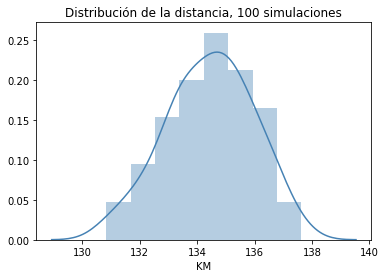

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.distplot(rutas.km, color="steelblue")
plt.title('Distribución de la distancia, 100 simulaciones')
plt.xlabel('KM', fontsize=10)

In [20]:
resumen = rutas.groupby('ruta').size().reset_index(name='Count').rename(columns={'Col1':'Col_value'})
resumen.describe()

,Count
count,100.0
mean,1.0
std,0.0
min,1.0
25%,1.0
50%,1.0
75%,1.0
max,1.0
